# Домашнее задание 2. Классификация, детекция.


Оценка за часть 1 и часть 2 в этом дз -- по 5 баллов.

## Часть 1. Классификация

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в датасете есть. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train и val, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат собственно сами изображения.
 
__Задание__. Добейтесь accuracy **не менее 0.44**. Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи/блогпосты/вопросы на stackoverflow/видосы от (индийских) ютуберов/курсы/подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

В коде ниже необходимо, чтобы код проходил все `assert`'ы.

Необходимо написать функцию `predict` по шаблону ниже. Эта функция принимает на вход модель, даталоадер с валидационнами данными, criterion для подсчёта лосса и device, на котором будут производиться вычисления (определён ниже) и возвращает список лоссов по всем объектам, список из предсказанных классов для каждого объекта из из даталоалера и список из настоящих классов для каждого объекта в даталоадере (и именно в таком порядке).

__Использовать внешние данные для обучения строго запрещено__. Можно использовать предобученные модели из `torchvision`.

__Критерии оценки__: Оценка вычисляется по простой формуле: min(5, 5 * Ваша accuracy / 0.44). Оценка округляется до десятых по арифметическим правилам.

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать на защите :)
 - Используйте аугментации. Для этого пользуйтесь модулем torchvision.transforms или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - (ещё раз) Можно файнтюнить предобученные модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом ImageFolder), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы отладить код, пробуйте обучаться на маленькой части датасета. Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать гпу. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

In [ ]:
# ! rm -r dataset
# ! rm -r dataset.zip
# ! rm -r sample_data

rm: cannot remove 'dataset.zip': No such file or directory


In [2]:
import random
import torch
import numpy as np
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [ ]:
# https://github.com/wldhx/yadisk-direct # воспользуемся гайдом
!pip3 install wldhx.yadisk-direct

Так как я превысил кол-во скачиваний пришлось использовать googleDisk

In [3]:
#  !curl -L $(yadisk-direct https://yadi.sk/d/dI8NrPZAugqtVg) -o dataset.zip #скачаем
!unzip /content/drive/MyDrive/dataset.zip > /dev/null  # распакуем
# !rm dataset.zip # удалим 

In [7]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
import numpy as np
# You may add any imports you need
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt
import glob
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, Normalize, ToTensor, Compose, RandomHorizontalFlip 
from torch.utils.data import DataLoader
from PIL import Image
from torchvision import  models

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform):
        # YOUR CODE
        self.dataset = ImageFolder(root=data_dir, transform=transform)
    def __getitem__(self, idx):
        # YOUR CODE
        return self.dataset[idx]
    def __len__(self, idx=None):
        # YOUR CODE
        return len(self.dataset)

Будем использовать размер картинок 224x224, так как Resnet обучали именно на таких картинках

Поигрался с фильтрами, но никакого эффекта это не дало, интерполяция которая используется по дефолту вполне хорошо работает. 
BILINEAR - используется по дефолту.
Все фильтры можно найти [тут](https://pillow.readthedocs.io/en/latest/handbook/concepts.html#filters)

Статья про ResNet [тут](https://arxiv.org/pdf/1512.03385.pdf)

Так как мы будем использовать ResNet, то и обучать будем так как его обучали на imagenet, то есть картинки 224x224, и SGD+momentum

In [8]:

width = 224
height = 224

train_transform = Compose([Resize((width,height),interpolation=Image.BILINEAR), ToTensor(), 
                           Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                           RandomHorizontalFlip(p=0.5)])
val_transform = Compose([Resize((width, height), interpolation=Image.BILINEAR), ToTensor(), Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), ])

train_dataset = MyDataset("./dataset/dataset/train", transform=train_transform)
val_dataset = MyDataset("./dataset/dataset/val", transform=val_transform)


In [9]:
# Just very simple checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


In [10]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:0"):
    model.to(device).train()
    losses = []
    with tqdm(total=len(train_dataloader)) as pbar:
      for imgs.to(device), labels.to(device) in train_dataloader:
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        _, predicted = torch.max(outputs.detach(), 1)
        accuracy = accuracy_score(predicted.cpu(), labels.cpu())
        pbar.set_description('Loss: {:.4f}; Accuracy: {:.4f}%'.format(loss.item(), 100*accuracy))    
        pbar.update(1)

def predict(model, val_dataloder, criterion, device="cuda:0"):
    model.to(device).eval()
    losses = []
    predicted_classes = []
    true_classes = []
    with tqdm(total=len(val_dataloader)) as pbar:
      with torch.no_grad():
        for imgs.to(device), labels.to(device) in val_dataloader:
          outputs = model(imgs)
          loss = criterion(outputs, labels)

          losses.append(loss.item())
          _, predicted = torch.max(outputs, 1)
          predicted_classes.append(predicted)
          true_classes.append(labels)
          accuracy = accuracy_score(predicted.cpu(), labels.cpu())

          pbar.set_description('Loss: {:.4f}; Accuracy: {:.4f}%'.format(loss.item(), 100*accuracy))
          pbar.update(1)

    predicted_classes = torch.cat(predicted_classes).detach().to('cpu').numpy()
    true_classes = torch.cat(true_classes).detach().to('cpu').numpy()
    return losses, predicted_classes, true_classes


def train(model, train_dataloader, val_dataloader, criterion, optimizer, device="cuda:0", n_epochs=10, scheduler=None):
    model.to(device)
    lrs = []
    for epoch in range(n_epochs):
        print('Learning rate: ', optimizer.param_groups[0]['lr'])
        print('Epoc:', epoch)
        train_one_epoch(model, train_dataloader, criterion, optimizer)
        print('Validation')
        losses, predicted_classes, true_classes = predict(model, val_dataloader, criterion)
        print('Accuracy: ', accuracy_score(true_classes, predicted_classes))
        lrs.append(optimizer.param_groups[0]['lr'])
        scheduler.step()
    plt.plot(lrs)

In [13]:
model = models.resnet50(pretrained=True)

model.fc = torch.nn.Linear(model.fc.in_features, 200)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=64, num_workers=4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.05)
n_epochs = 2

Простой тест на проверку правильности написанного кода

In [14]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(predicted_labels, true_labels)
print("tests passed")

Loss: 5.1216; Accuracy: 0.0000%: 100%|██████████| 157/157 [00:32<00:00,  4.84it/s]

tests passed


Запустить обучение можно в ячейке ниже.

In [15]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler)

  0%|          | 0/1563 [00:00<?, ?it/s]

Learning rate:  0.001
Epoc: 0


  0%|          | 0/157 [00:00<?, ?it/s]

Validation


  0%|          | 0/1563 [00:00<?, ?it/s]

Accuracy:  0.7432
Learning rate:  5e-05
Epoc: 1


Loss: 1.0903; Accuracy: 78.1250%:   6%|▌         | 86/1563 [01:02<17:57,  1.37it/s]


KeyboardInterrupt: ignored

После всех экспериментов которые вы проделали, выберите лучшую из своих моделей, запустите функцию evaluate. Эта функция должна брать на вход модель и даталоадер с валидационными данными и возврашать accuracy, посчитанную на этом датасете.

In [16]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(true_labels, predicted_labels)
print("Оценка за это задание составит {} баллов".format(min(5, 5*accuracy / 0.44)))
print('Accuracy: ', accuracy)

Loss: 0.9759; Accuracy: 87.5000%: 100%|██████████| 157/157 [00:34<00:00,  4.55it/s]

Оценка за это задание составит 5 баллов
Accuracy:  0.7468


Ого:) А только первая эпоха!!! Представляете, что будет на 10?! Правильно!!! 0.82...:(

__Ваш отчёт о проделанных экспериментах__: текст писать тут
Тут было самое главное подобрать оптимизатор, Adam работал очень плохо, RMSprop средне, самый лучший результат показал SGD. Так же когда делал доп задание и борьба шла за десятки...то очень хорошо работало расписание.

## Часть 2. Object detection.

В этом задании потребуется обучить детектор фруктов на изображении. Датасет можно скачать [отсюда](https://yadi.sk/d/UPwQB7OZrB48qQ).

In [17]:
#сделаем все так как и в первом задании
!pip3 install wldhx.yadisk-direct

In [18]:
!curl -L $(yadisk-direct https://yadi.sk/d/UPwQB7OZrB48qQ) -o detection.zip #скачаем
!unzip detection.zip > /dev/null  # распакуем
!rm detection.zip # удалим 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 28.3M  100 28.3M    0     0  6826k      0  0:00:04  0:00:04 --:--:-- 9696k
replace test_zip/test/apple_77.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [62]:

import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import xmltodict
import json
import glob
import cv2
import os
import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import albumentations as A
from albumentations.pytorch.transforms import ToTensor 

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn



In [20]:
# we will need this library to process the labeling
! pip install xmltodict

In [60]:
! pip install --upgrade torchvision

Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.8.1+cu101)


In [39]:
# иначе он не знает, что такое BboxParams
! pip install --upgrade albumentations

Requirement already up-to-date: albumentations in /usr/local/lib/python3.6/dist-packages (0.5.2)


In [22]:
import xmltodict, json

Датасет мы за вас написали.

In [24]:
class2tag = {"apple": 1, "orange": 2, "banana": 3}

class FruitDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images = []
        self.annotations = []
        self.transform = transform
        for annotation in glob.glob(data_dir + "/*xml"):
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            self.images.append(cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB))
            with open(annotation) as f:
                annotation_dict = xmltodict.parse(f.read())
            bboxes = []
            labels = []
            objects = annotation_dict["annotation"]["object"]
            if not isinstance(objects, list):
                objects = [objects]
            for obj in objects:
                bndbox = obj["bndbox"]
                bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
                bbox = list(map(int, bbox))
                bboxes.append(torch.tensor(bbox))
                labels.append(class2tag[obj["name"]])
            self.annotations.append(
                {"boxes": torch.stack(bboxes).float(), "labels": torch.tensor(labels)}
            )

    def __getitem__(self, i):
        if self.transform:
            # the following code is correct if you use albumentations
            # if you use torchvision transforms you have to modify it =)
            res = self.transform(
                image=self.images[i],
                bboxes=self.annotations[i]["boxes"],
                labels=self.annotations[i]["labels"],
            )
            return res["image"], {
                "boxes": torch.tensor(res["bboxes"]),
                "labels": torch.tensor(res["labels"]),
            }
        else:
            return self.images[i], self.annotations[i]

    def __len__(self):
        return len(self.images)

Выпишем кое-какую техническую работу, которая уже была на семинаре.

In [25]:
def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """

    ## TODO YOUR CODE

    intersection_bbox = np.array(
        [
            max(dt_bbox[0], gt_bbox[0]),
            max(dt_bbox[1], gt_bbox[1]),
            min(dt_bbox[2], gt_bbox[2]),
            min(dt_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou

def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
    gt_bboxes = target_true["boxes"].numpy()
    gt_labels = target_true["labels"].numpy()

    dt_bboxes = target_pred["boxes"].numpy()
    dt_labels = target_pred["labels"].numpy()
    dt_scores = target_pred["scores"].numpy()

    results = []
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {"score": dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            detection_result_dict["TP"] = 1
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict["TP"] = 0

        results.append(detection_result_dict)

    return results


def evaluate(model, test_loader, device):
    results = []
    model.to(device).eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)
            targets_true = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_true
            ]
            targets_pred = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_pred
            ]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true["labels"].shape[0]

                results.extend(evaluate_sample(target_pred, target_true))

    results = sorted(results, key=lambda k: k["score"], reverse=True)

    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

Вам мы оставляем творческую часть =)

__Задание__. Обучите модель для object detection на __обучающем__ датасете и добейтесь PR-AUC не менее __0.91__ на  __тестовом__.

 - Создайте модель и оптимайзер
 - Напишите функцию обучения модели
 - Используйте аугментации
 
Использовать аугментации для обучения __обязательно__. Они дадут 1 балл из 5. Пользуйтесь модулем torchvision.transforms или библиотекой albumentations (о которой говорилось ранее). Последняя библиотека особенно удобна, поскольку умеет сама вычислять новые координаты bounding box'ов после трансформаций картинки. Советуем обратить внимание на следующий [гайд](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). Обратите внимание, что код, написанный в датасете выше, верен только если вы используете albumentations. Если вы выбрали путь torchvision.transforms, вам потребуется метод `__getitem__` изменить (что-то типа `return self.transform(self.images[i])`; однако в таком случае вычислять новые координаты bounding box'ов после трансформаций вам придётся вручную =))

Оставшиеся 4 балла вычисляются по простой формуле: __min(4, 4 * Ваш auc / 0.91)__.

In [46]:
# возьмем код с 7 семинара и добавим прогресс бар
def train_one_epoch(model, train_dataloader, optimizer, device):
    model.to(device).train()
    n = 0
    global_loss = 0
    with tqdm(total=len(train_dataloader)) as bar:
      for images, targets in train_dataloader:
        images = list(image.to(device).float() for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        dict_loss = model(images, targets)
        losses = sum(loss for loss in dict_loss.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        n += 1
        global_loss += float(losses.cpu().detach().numpy())

        bar.set_description("Loss value {:.4f}".format(global_loss / n))
        bar.update(1)

    return global_loss

def train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs=10, scheduler=None):
    model.to(device)
    for epoch in range(n_epochs):
      print('Epoc:', epoch)
      train_one_epoch(model, train_dataloader, optimizer, device=device)
      eval = evaluate(model, val_dataloader, device=device)
      print("AUC ON TEST: {:.4f}".format(eval))
      if scheduler:
          scheduler.step()
        

In [47]:
 model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 4) #3 класса + 1 фон = 4(это математика)

def collate_fn(batch):
    return tuple(zip(*batch))

In [52]:
train_transform = A.Compose([A.HorizontalFlip(p=0.5),
                             A.Rotate(limit=45, border_mode=cv2.BORDER_REPLICATE, p=0.5),
                           A.RandomBrightnessContrast(p=0.4),
                           A.RandomGamma(p=0.3),
                           ToTensor()],
                           A.BboxParams(format='pascal_voc',label_fields=[],))
val_transform = A.Compose([ToTensor()], A.BboxParams(format='pascal_voc',label_fields=[],))

train_dataset = FruitDataset("./train_zip/train", transform=train_transform)
val_dataset = FruitDataset("./test_zip/test", transform=val_transform)
parameters = [param for param in model.parameters() if param.requires_grad]
optimizer = torch.optim.SGD(parameters, lr=0.005, momentum=0.9,weight_decay=0.0005) # с семинара
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=2, collate_fn=collate_fn)
n_epochs = 10 
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model.to(device);


In [54]:
import warnings 
warnings.filterwarnings('ignore')
train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs)

  0%|          | 0/120 [00:00<?, ?it/s]

Epoc: 0


  0%|          | 0/120 [00:00<?, ?it/s]

AUC ON TEST: 0.7267
Epoc: 1


  0%|          | 0/120 [00:00<?, ?it/s]

AUC ON TEST: 0.8239
Epoc: 2


  0%|          | 0/120 [00:00<?, ?it/s]

AUC ON TEST: 0.8813
Epoc: 3


  0%|          | 0/120 [00:00<?, ?it/s]

AUC ON TEST: 0.8813
Epoc: 4


  0%|          | 0/120 [00:00<?, ?it/s]

AUC ON TEST: 0.8764
Epoc: 5


Loss value 0.1609:  15%|█▌        | 18/120 [00:14<01:20,  1.27it/s]


KeyboardInterrupt: ignored

__Выведите итоговое качество модели__.

In [55]:
auc = evaluate(model, val_dataloader, device)
print(auc)
print("Оценка за это задание составит {} баллов".format(min(4, 4 * auc / 0.91)))

0.8941723355379576
Оценка за это задание составит 3.930427848518495 баллов


Нарисуйте предсказанные bounding box'ы для любых двух картинок из __тестового__ датасета.

In [69]:
image, labels = next(iter(train_dataset))
pred = model(image.unsqueeze(0).to(device))[0]

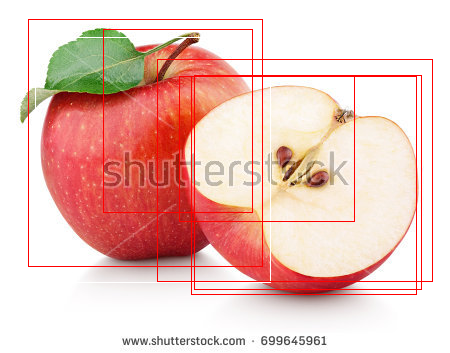

In [70]:
from PIL import ImageDraw
from torchvision import transforms

image = torchvision.transforms.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

## Бонус (10 баллов).

__Задание__. В части с классификацией добейтесь accuracy не менее 0.52. Напишите отчёт о проделанных экспериментах.

__Критерии оценки__. Оценка за бонусную часть равна 10, если вы преодолели качество 0.52 и 0 в противном случае.

__Иных оценок кроме 0 и 10 не предусмотрено__.

In [71]:
# чуть позже отправлю